In [2]:
import sys
print sys.prefix
print sys.executable
import os
print os.getcwd()

C:\Users\Rdebbout\AppData\Local\Continuum\Anaconda2\envs\sdmg
C:\Users\Rdebbout\AppData\Local\Continuum\Anaconda2\envs\sdmg\python.exe
C:\Users\Rdebbout\Plot2Shps\SDMG


# Download this directory! 
[Click to download data for Exercise](https://www.dropbox.com/sh/dzc4b5hsn0dc9vf/AABrX5NoR6W-gakT3Wbdmxo9a?dl=1 "Download")

# Point to where you have extracted the data below

In [3]:
DL_dir='/home/rick/Downloads/SpatialData' #change this to the location of the download

In [6]:
% matplotlib inline
import geopandas as gpd

In [45]:
# load into GeoDataFrame directly from shapefile
lakes = gpd.GeoDataFrame.from_file("{}/NHDPlus16/NHDWaterbodies.shp".format(DL_dir))
print lakes.crs  #find the coordinate reference system -- GCS_North_American_1983

{'init': u'epsg:4269'}


In [46]:
# attribute table
import pandas as pd
print len(pd.unique(lakes.REACHCODE))
#lakes.set_index('REACHCODE', inplace=True)
lakes.head()

797


,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
REACHCODE,,,,,,,,,,,,,
16010202001481,0.079,4562850,0.0,39004,1999-06-22,LakePond,None,None,Medium,0.000009,0.019938,16,"POLYGON ((-111.855203003485 41.90411666828982,..."
16010203000737,0.102,663806,0.0,39004,1999-06-22,LakePond,1446649,Tony Grove Lake,Medium,0.000011,0.015252,16,POLYGON ((-111.6456740038103 41.89611300163557...
16010203000755,0.036,663946,0.0,39004,1999-06-22,LakePond,None,None,Medium,0.000004,0.011745,16,POLYGON ((-111.7176358036986 41.75337126852378...
16010203000753,1.044,663954,1343.0,39010,1999-06-22,LakePond,None,None,Medium,0.000113,0.224490,16,"POLYGON ((-111.9423262033498 41.7297770685604,..."
16010203000746,0.037,663956,1343.0,39010,1999-06-22,LakePond,None,None,Medium,0.000004,0.010551,16,POLYGON ((-111.9461004700106 41.74514726853653...


In [65]:
print type(lakes.FTYPE)
print lakes.FTYPE[0] # returns index in the series, change to index of REACHCODE above if that was index set

<class 'pandas.core.series.Series'>
LakePond


In [48]:
print lakes.dtypes

AREASQKM      float64
COMID           int64
ELEVATION     float64
FCODE           int64
FDATE          object
FTYPE          object
GNIS_ID        object
GNIS_NAME      object
RESOLUTION     object
SHAPE_AREA    float64
SHAPE_LENG    float64
VPU            object
geometry       object
dtype: object


In [49]:
print lakes.index.dtype
print lakes.index

object
Index([u'16010202001481', u'16010203000737', u'16010203000755',
       u'16010203000753', u'16010203000746', u'16010203000756',
       u'16010203000757', u'16010203000766',              None,
       u'16010102000947',
       ...
       u'16060002001151', u'16060008003973', u'16060008004010',
       u'16060012004685', u'16060012004682', u'16060012004715',
       u'16060007002618', u'16060003001894', u'16060009001899',
       u'16060007002486'],
      dtype='object', name=u'REACHCODE', length=807)


807


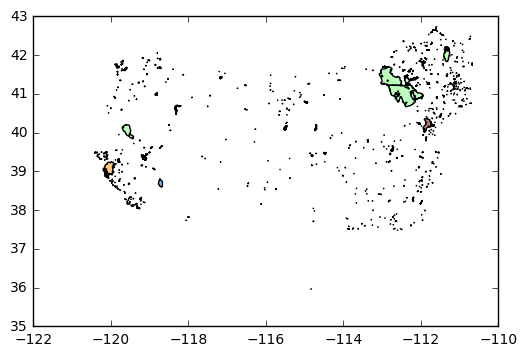

In [47]:
print len(lakes)
lakes.plot()  #Visualize

In [ ]:
lakes.plot?

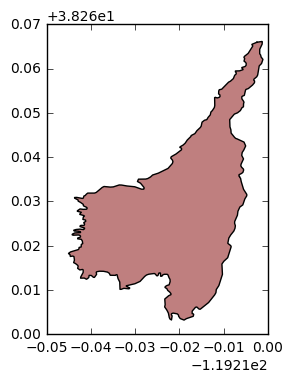

In [50]:
lake = lakes.ix[lakes.COMID == 8914219] 
lake.plot()  # add figsize

In [53]:
#cats = gpd.GeoDataFrame.from_file("{}/NHDPlus16/NHDCatchment.shp".format(DL_dir))
#basin = cats.ix[cats.FEATUREID.isin(range(8915961,8915984,2))]
print basin.AreaSqKM.max()
print basin.AreaSqKM.min()
print basin.AreaSqKM.mean()
print basin.AreaSqKM.std()
#basin.plot()

11.8476
0.3078
3.5319
3.79137471038


In [63]:
#basin.AreaSqKM.cumsum().values[-1]
type(basin.AreaSqKM.cumprod().values)
#basin.AreaSqKM.cumprod()

numpy.ndarray

In [ ]:
sort_values()

In [18]:
def fn_test(x):  # Delete this
    keep = []
    for uid in range(x,8915984,2):
        keep.append(cats.ix[cats.FEATUREID==uid].index.values[0])
    return keep

In [20]:
lakes.loc?

In [74]:
#lakes.loc[lakes['COMID'] == 4562850]
#lakes.ix[lakes.COMID == 4562850]
#lakes.ix[lakes.COMID.isin([4562850])]
lakes.query("COMID == 4562850")
lakes.query?
#cats.loc[fn_test(8915961)]

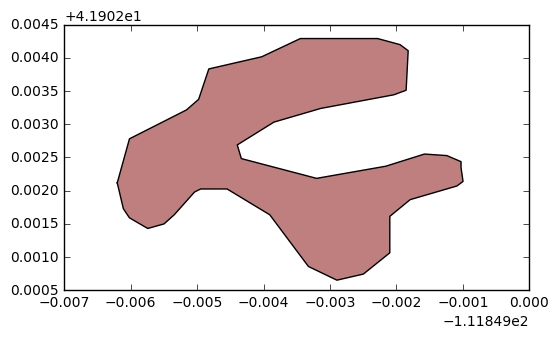

In [69]:
lakes.ix[lakes.COMID.isin([4562850])].plot()

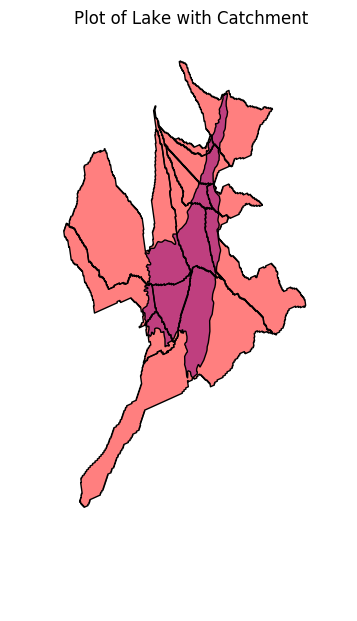

In [77]:
import matplotlib.pyplot as plt
#plt.style.use("default")
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = lake.plot(ax=ax, color='blue')
basin.plot(ax=base, color='red') #
ax.axis('off')
ax.set_title("Plot of Lake with Catchment")

In [78]:
?gpd.GeoDataFrame.plot

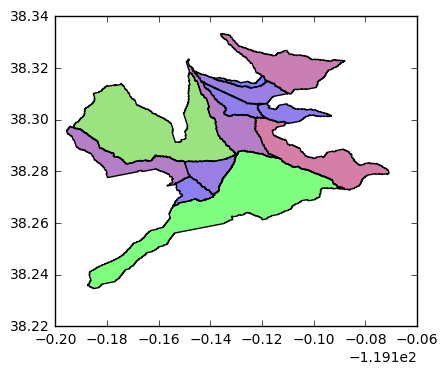

In [23]:
basin.plot(column='AreaSqKM', cmap="brg")

In [ ]:
print type(basin['geometry'])
print type(basin.ix[0].geometry) # key in on output from this
print basin.ix[0].geometry.area
print basin.ix[0].geometry.length
#convert to new crs for output in meteres
basin_albers = basin.to_crs({'init' :'epsg:5070'})
print basin_albers.ix[0].geometry.area
print basin_albers.ix[0].geometry.length

In [79]:
lake.to_json()

'{"type": "FeatureCollection", "features": [{"geometry": {"type": "Polygon", "coordinates": [[[-119.21250939206504, 38.32593747384385], [-119.21134779206682, 38.32612140717691], [-119.21128959206692, 38.32605280717701], [-119.21131799206688, 38.32552647384449], [-119.21186839206604, 38.324359073846324], [-119.21186719206605, 38.323352407181176], [-119.21166352539967, 38.32305507384831], [-119.21154679206654, 38.32259760718239], [-119.21113952540048, 38.322071607183204], [-119.21145772540001, 38.32113327385133], [-119.21197992539919, 38.32060660718548], [-119.21232612539865, 38.31854700718867], [-119.21252879206497, 38.31815787385591], [-119.21316712539732, 38.31760820719012], [-119.21322492539724, 38.317379273857114], [-119.21302132539756, 38.31719647385739], [-119.21304992539751, 38.316807473858034], [-119.21348479206353, 38.31628087385883], [-119.21444219206205, 38.31547927386009], [-119.21496492539455, 38.315295807193706], [-119.21508079206103, 38.315089807194], [-119.21534072539396

In [ ]:
findUpstreamNpy.func_code
#import os
#os.getcwd()

In [ ]:
lks = gpd.GeoDataFrame()
bsn = gpd.GeoDataFrame()
miss = gpd.GeoDataFrame()

for idx, row in lookup.iterrows():
    lake = lakes.ix[lakes.COMID == row.wbCOMID]
    catbas = findUpstreamNpy(zone, int(row.catCOMID), assc8dArrays)
    basin = cats.ix[cats.FEATUREID.isin(catbas)]
    try: 
        diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
        pct = diffgeom.area / lake.area * 100
        if pct.values[0] > 50:
            lks = pd.concat([lks, lake])
            bsn = pd.concat([bsn, basin])
            miss = pd.concat([miss, gpd.GeoDataFrame(geometry=diffgeom)])
    except:
        print row.wbCOMID
        continue

In [ ]:
import folium

# Querying attributes

In [ ]:
lks.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\lks.json",driver="GeoJSON")
bsn.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\bsn.json",driver="GeoJSON")
miss.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\miss.json",driver="GeoJSON")

In [ ]:
center_point = lakes.unary_union.buffer(0).centroid
print center_point.x
print center_point.y

In [ ]:
import folium
map=folium.Map(location=[45.96040854768601, -117.47340297823],zoom_start=6,tiles="Stamen Terrain")
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name in zip(lks['geometry'].centroid.map(lambda p: p.y),lks['geometry'].centroid.map(lambda p: p.x),lks['COMID']):
        fg.add_child(folium.Marker(location=[lat,lon],popup=name.map(lambda x: "NHD Waterbody COMID: %s" % x),
                                   icon=folium.Icon(icon_color='black')))
map.add_child(fg)
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\lks.json'),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 'fill_opacity': 0.2, 'color':'black'}))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\bsn.json'),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                          'fill_opacity': 0.47,}))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\miss.json'),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 'fill_opacity': 0.2, 'color':'none'}))
map.add_child(folium.LayerControl())
map.save(outfile=r'C:\Users\Rdebbout\Plot2Shps\lakesPoint.html')

In [ ]:
for lat,lon,name in zip(lks['geometry'].centroid.map(lambda p: p.y),lks['geometry'].centroid.map(lambda p: p.x),lks['COMID']):
    print "Lat: {} \nLon: {} \nCOMID: {}".format(lat,lon,name)

In [ ]:
lks2 = gpd.GeoDataFrame()
bsn2 = gpd.GeoDataFrame()
miss2 = gpd.GeoDataFrame()
for zone in inputs:
    hr = inputs[zone]
    lakes = lksnet.ix[lksnet.VPU == zone]  
    cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDPlus%s/NHDPlusCatchment/Catchment.shp' % (NHD_dir,hr, zone))   
    lookup = pd.read_csv('D:/Projects/lakesAnalysis/On_Network_LakeCOMs/LakeCOMs%s.csv' % zone)
    for idx, row in lookup.iterrows():
        lake = lakes.ix[lakes.COMID == row.wbCOMID]
        catbas = findUpstreamNpy(zone, int(row.catCOMID), catnumps)
        basin = cats.ix[cats.FEATUREID.isin(catbas)]
        try: 
            diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
            pct = diffgeom.area / lake.area * 100
            if pct.values[0] > 50:
                lks2 = pd.concat([lks2, lake])
                bsn2 = pd.concat([bsn2, basin])
                miss2 = pd.concat([miss2, gpd.GeoDataFrame(geometry=diffgeom)])
        except:
            print row.wbCOMID
            continue

In [ ]:
% timeit
lks2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\lks3.json",driver="GeoJSON")
bsn2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\bsn3.json",driver="GeoJSON")
miss2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\miss3.json",driver="GeoJSON")

In [ ]:
map=folium.Map(location=[45.96040854768601, -117.47340297823],zoom_start=6,tiles="Stamen Terrain")

fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name in zip(lakes['geometry'].centroid.map(lambda p: p.y),lakes['geometry'].centroid.map(lambda p: p.x),lakes['COMID']):
        fg.add_child(folium.Marker(location=[lat,lon],popup='NHD Waterbody COMID: %s' % name,
                                   icon=folium.Icon(icon_color='white', prefix='fa',icon='warning')))
map.add_child(fg)

map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\lks.json'),
name='NHD Lake',
style_function=lambda x: {'fillColor':'blue', 'fill_opacity': 0.4, 'color':'#5bc0de'}
))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\bsn.json'),
name='Catchment Basin',
style_function=lambda x: {'fillColor':'grey', 
                          'fill_opacity': 0.3, 
                          'color':'white'}
))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\miss.json'),
name='Missed Area',
style_function=lambda x: {'fillColor':'red', 'fill_opacity': 0.2, 'color':'none'}
))
map.add_child(folium.LayerControl())
map.save(outfile=r'C:\Users\Rdebbout\Plot2Shps\lakesPoint.html')

In [ ]:
def color(vpu):
    if vpu in ['09','16','08','03N']:
        col='#d9534f'
    elif vpu in ['10U','05','13','03S']:
        col='#f9f9f9'
    elif vpu in ['14','07','02','12']:
        col='#5bc0de'
    elif vpu in ['17','10L','04','06','15']:
        col='#5cb85c'
    elif vpu in ['18','11','01','03W']:
        col='#428bca'
    return col

In [ ]:
extent = lks2.unary_union.bounds
lat_Center = (extent[1] + extent[3]) / 2
lon_Center = (extent[0] + extent[2]) / 2

In [ ]:
lks.unary_union.centroid.y
lks.unary_union.centroid.x